# 参数优化器

1. 优化IC
2. 优化Ann RET
3. 优化IR

## 1_优化IC
1. 读取本地相应数据
2. 设置Optimizer()
3. 优化IC启动枚举enumerate_optimizer()
4. 获取最优结果的signal_data与performance

**1. 读取本地相应数据**

In [1]:
import numpy as np
from jaqs.data import DataView
from jaqs.research import SignalDigger
import warnings

warnings.filterwarnings("ignore")
dataview_folder = 'JAQS_Data/hs300'
dv = DataView()
dv.load_dataview(dataview_folder)

D:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Dataview loaded successfully.


In [2]:
def mask_index_member():
    df_index_member = dv.get_ts('index_member')
    mask_index_member = df_index_member ==0 #定义信号过滤条件-非指数成分
    return mask_index_member

def limit_up_down():
    # 定义可买卖条件——未停牌、未涨跌停
    trade_status = dv.get_ts('trade_status')
    mask_sus = trade_status == u'停牌'
    # 涨停
    dv.add_formula('up_limit', '(close - Delay(close, 1)) / Delay(close, 1) > 0.095', is_quarterly=False)
    # 跌停
    dv.add_formula('down_limit', '(close - Delay(close, 1)) / Delay(close, 1) < -0.095', is_quarterly=False)
    can_enter = np.logical_and(dv.get_ts('up_limit') < 1, ~mask_sus) # 未涨停未停牌
    can_exit = np.logical_and(dv.get_ts('down_limit') < 1, ~mask_sus) # 未跌停未停牌
    return can_enter,can_exit

In [3]:
mask = mask_index_member()
can_enter,can_exit = limit_up_down()
price = dv.get_ts('close_adj')
price_bench = dv.data_benchmark

Add formula failed: name [up_limit] exist. Try another name.
Add formula failed: name [down_limit] exist. Try another name.


**2.初始化Optimizer()**

In [4]:
# 优化因子
from jaqs.research import Optimizer
algorithm_opt = Optimizer(dataview=dv,
                      formula='- Correlation(vwap_adj, volume, LEN)',
                      params={"LEN":range(2,15,1)},
                      name='Cor_Vwap_Volume',
                      price=price,
                      benchmark_price=None,#=None求绝对收益 #=price_bench求相对收益
                      period=5,
                      n_quantiles=5,
                      mask=mask,
                      can_enter=can_enter,
                      can_exit=can_exit,
                      commission=0.0008,#手续费 默认0.0008
                      is_event=False,#是否是事件(0/1因子)
                      is_quarterly=False)#是否是季度因子 默认为False

In [5]:
# dv.remove_field()

**3. 枚举优化enumerate_optimizer()**

In [6]:
algorithm_ic_opt = algorithm_opt.enumerate_optimizer(target_type="ic",
                                     target="IC Mean",
                                     in_sample_range=[20170101,20170701],
                                     ascending=False)

可选的优化类型仅能从['long_ret', 'short_ret', 'long_short_ret', 'top_quantile_ret', 'bottom_quantile_ret', 'tmb_ret', 'return_ic', 'upside_ret_ic', 'downside_ret_ic', 'long_space', 'short_space', 'long_short_space', 'top_quantile_space', 'bottom_quantile_space', 'tmb_space']选取
Nan Data Count (should be zero) : 0;  Percentage of effective data: 52%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Cou

AttributeError: 'list' object has no attribute 'loc'

**4. 获取最优结果的signal_data与performance**

In [ ]:
algorithm_data_opt = algorithm_opt.all_signals.get(algorithm_ic_opt[0]["signal_name"])

In [ ]:
print(algorithm_data_opt.tail())

In [ ]:
print(algorithm_ic_opt[0]["signal_name"])
print(algorithm_ic_opt[0]["ret"])
print(algorithm_ic_opt[0]["ic"])

In [ ]:
import matplotlib.pyplot as plt

def signal_obj(signal, name, period, quantile):
    price = dv.get_ts('close_adj')
    price_bench = dv.data_benchmark

    obj = SignalDigger(output_folder="hs300/%s" % name,
                       output_format='pdf')

    obj.process_signal_before_analysis(signal,
                                   price=price,
                                   n_quantiles=quantile, period=period,
                                   benchmark_price=price_bench,
                                   can_enter = can_enter,
                                   can_exit = can_exit,
                                   mask=mask
                                   )
    obj.create_full_report()
    return obj
    
def signal_plot(signal, name, period=5, quantile=5):
    obj = signal_obj(signal, name, period, quantile)
    obj.fig_objs
    plt.show()
    
def signal_data(signal, name, period=5, quantile=5):
    obj = signal_obj(signal, name, period, quantile)
    return obj.signal_data

In [ ]:
dv.add_formula('Cor_Vwap_Volume','-Correlation(vwap_adj, volume, 8)', is_quarterly=False)

In [ ]:
signal_plot(dv.get_ts('Cor_Vwap_Volume'), 'Cor_Vwap_Volume')

## 2_优化Ann. IR
### 外部自定义算法
1. 设置Optimizer()
2. 生成字典并输入自定义算法计算出来的signal
2. 将all_signals赋值为signal字典
3. 优化Ann. Ret启动枚举enumerate_optimizer()
4. 将绩效图形化

**1. 设置Optimizer()**

In [13]:
import pandas as pd
import talib as ta

close = price.dropna(how='all', axis=1)
# TA_Signal = Optimizer(dataview=dv, params={'SLOPE_PARAM': None})

for i in range(2,9,1):
    dv.remove_field('SLOPE_PARAM='+str(i))

Field name [SLOPE_PARAM=2] does not exist.
Field name [SLOPE_PARAM=3] does not exist.
Field name [SLOPE_PARAM=4] does not exist.
Field name [SLOPE_PARAM=5] does not exist.
Field name [SLOPE_PARAM=6] does not exist.
Field name [SLOPE_PARAM=7] does not exist.
Field name [SLOPE_PARAM=8] does not exist.


**2. 生成字典并输入自定义算法计算出来的signal**

In [14]:
signals_dict = {}
for param in range(2,9,1):
    slope_df = pd.DataFrame({name: -ta.LINEARREG_SLOPE(value.values, param) for name, value in close.iteritems()}, index=close.index)
    slope_df.columns.name='symbol'
    dv.append_df(slope_df,'SLOPE_PARAM='+str(param))
    signals_dict['SLOPE_PARAM='+str(param)] = TA_Signal.cal_signal(dv.get_ts('SLOPE_PARAM='+str(param)))

Nan Data Count (should be zero) : 0;  Percentage of effective data: 94%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 94%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 94%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 94%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 94%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 94%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 93%


**3. 将all_signals赋值为signal字典 **

In [15]:
algorithm_opt.all_signals = signals_dict
# TA_Signal.all_signals_perf = None

**4. 优化Ann. Ret启动枚举enumerate_optimizer()**

In [16]:
ret_best = TA_Signal.enumerate_optimizer(target_type="long_ret",#优化目标类型
                                        target = "Ann. IR",
                                        in_sample_range=None,
                                        ascending=False)

In [17]:
print(ret_best[0]["signal_name"])
print(ret_best[0]["ret"])
print(ret_best[0]["ic"])

SLOPE_PARAM=2
           long_ret    short_ret  long_short_ret  top_quantile_ret  \
t-stat          NaN    -2.966772        1.207969         25.393054   
p-value         NaN     0.003060        0.227260          0.000000   
skewness        NaN     0.590704       -0.186353          0.608066   
kurtosis        NaN     6.942106       10.463923          6.706533   
Ann. Ret        NaN    -0.169683        0.045515          0.216955   
Ann. Vol        NaN     0.313052        0.206234          0.470349   
Ann. IR         NaN    -0.542029        0.220696          0.461264   
occurance    1451.0  1451.000000     1451.000000     146683.000000   

           bottom_quantile_ret      tmb_ret  
t-stat               13.325479     3.321635  
p-value               0.000000     0.000920  
skewness              1.423373     0.221381  
kurtosis             11.362313     6.096853  
Ann. Ret              0.122275     0.095795  
Ann. Vol              0.506822     0.157853  
Ann. IR               0.241259   

Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%


Value of signals of Different Quantiles Statistics
                min        max      mean       std  count    count %
quantile                                                            
1        -61.312805   1.228915 -1.111542  2.096910  83232  20.143223
2         -4.082553   2.203120 -0.144737  0.348554  82636  19.998984
3         -2.203622   3.422494  0.020581  0.304981  82633  19.998258
4         -1.309521   6.158563  0.185284  0.449757  82636  19.998984
5         -0.766401  67.490135  1.037780  2.141804  82064  19.860552
Figure saved: C:\Users\small\OneDrive\notebook\Internet_Course\4_Selection\JAQS_Plus\hs300\slope_opt\returns_report.pdf
Information Analysis
                ic
IC Mean      0.031
IC Std.      0.158
t-stat(IC)     NaN
p-value(IC)    NaN
IC Skew        NaN
IC Kurtosis    NaN
Ann. IR      0.198
Figure saved: C:\Users\small\OneDrive\notebook\Internet_Course\4_Selection\JAQS_Plus\hs300\slope_op

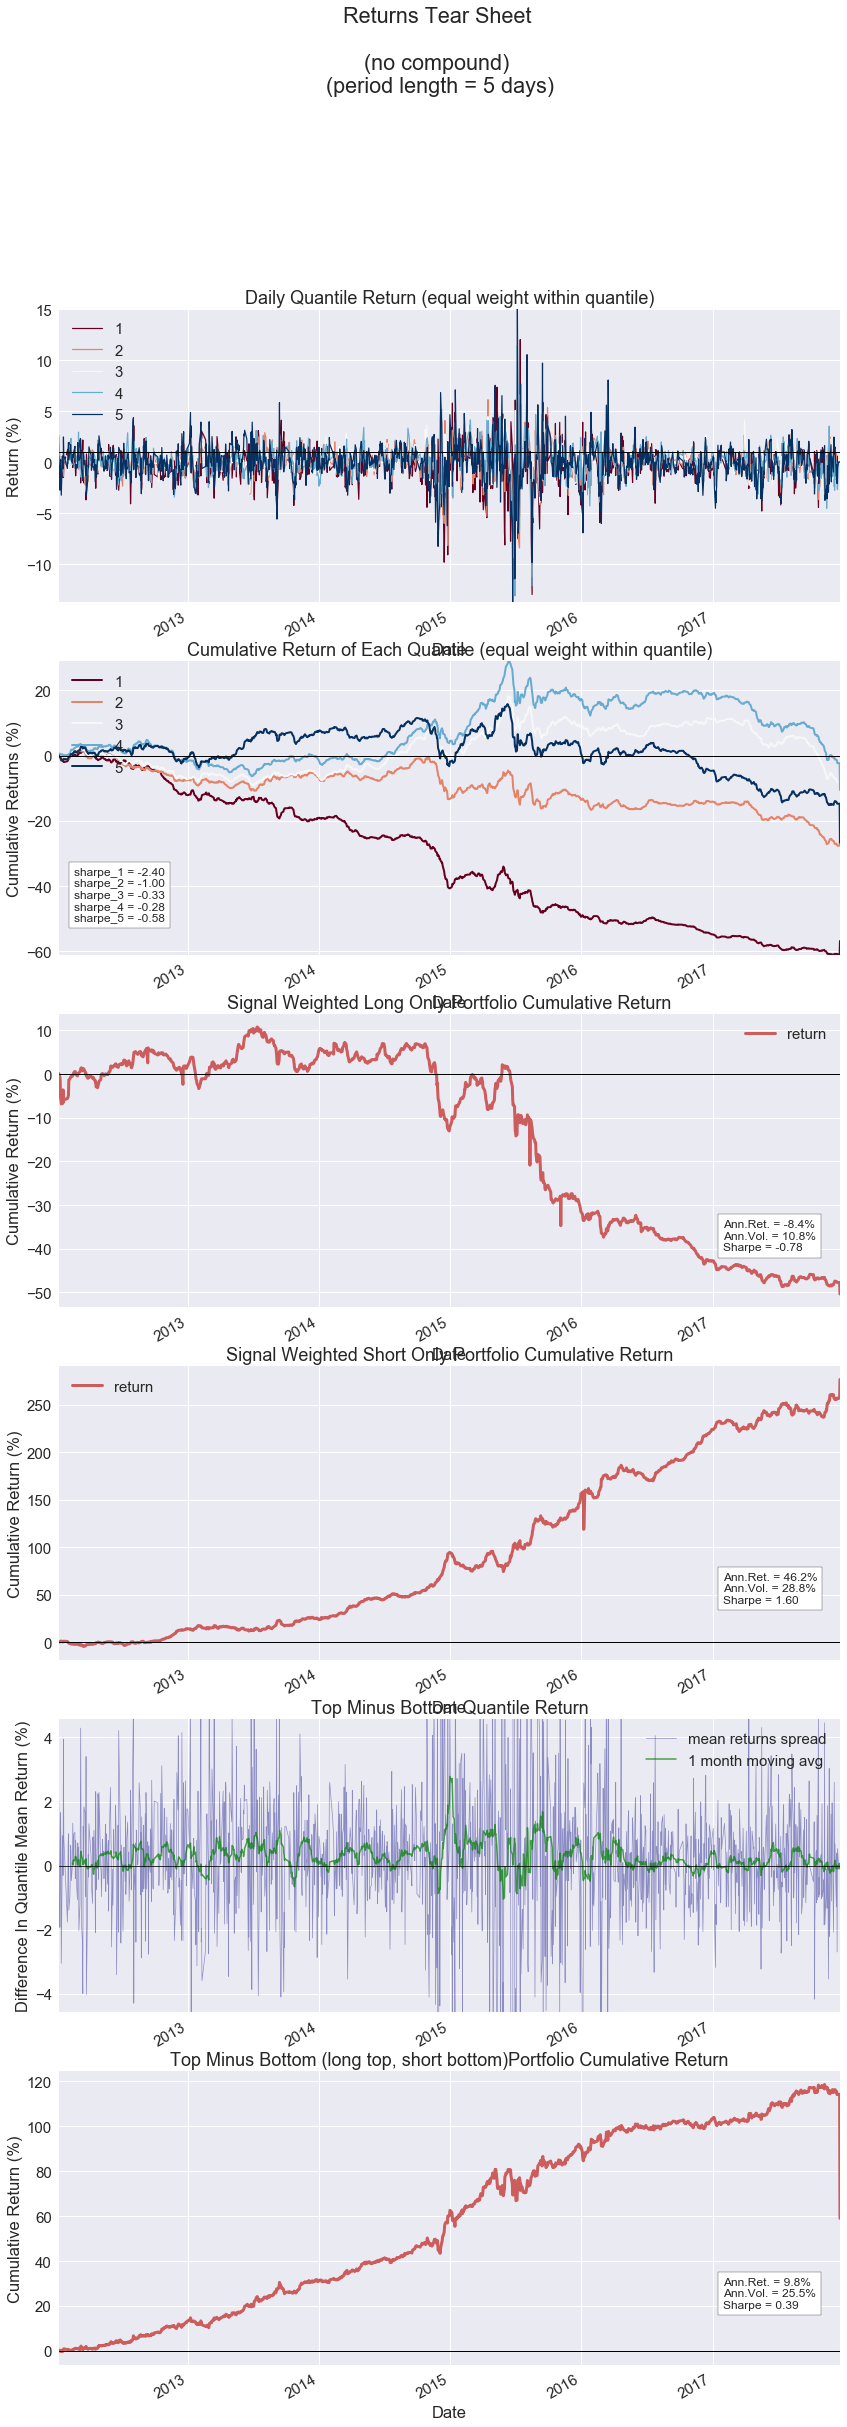

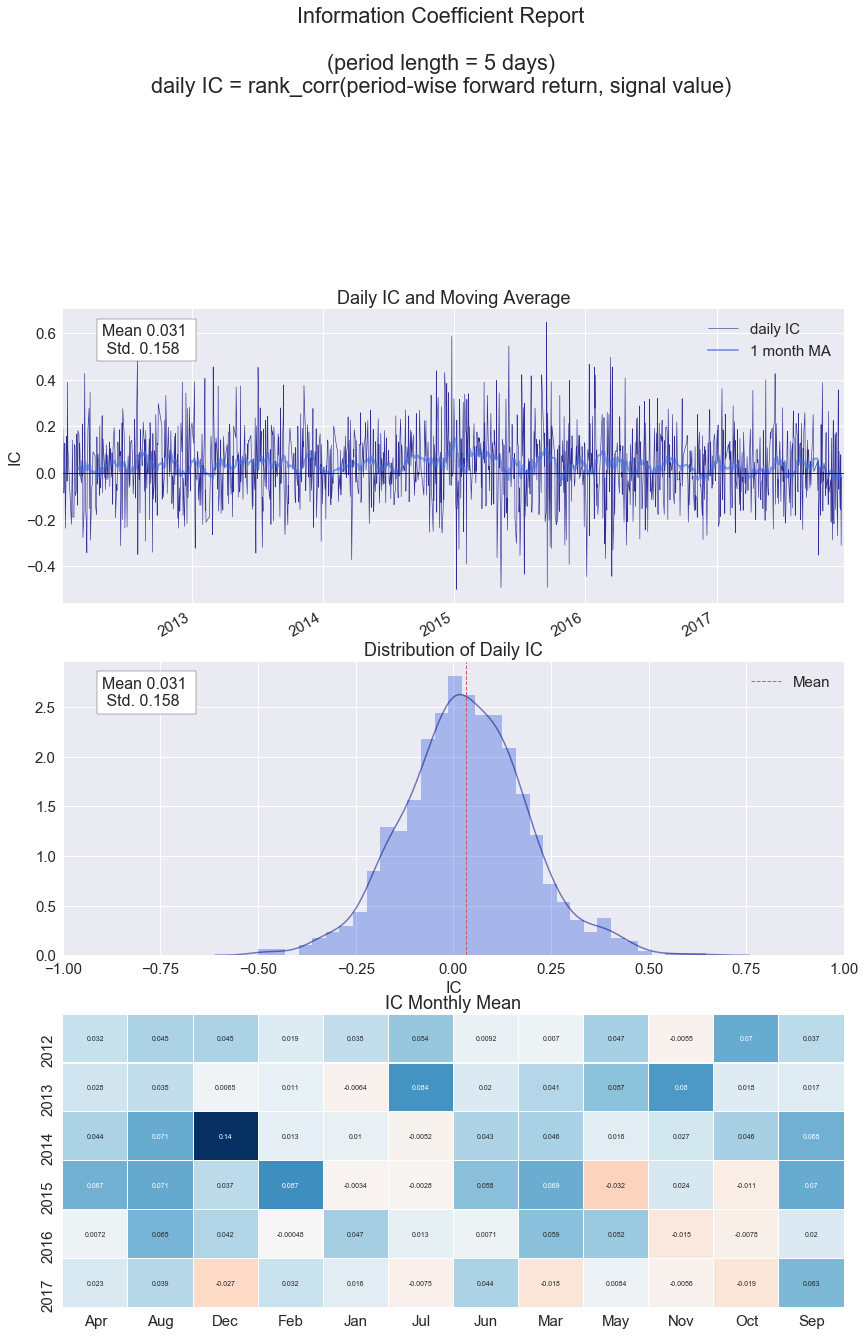

In [18]:
signal_plot(dv.get_ts(ret_best[0]["signal_name"]), 'slope_opt')

## 3_优化Ann. Ret
### 均线事件驱动
1. 设置事件驱动的Optimizer
2. 优化Ann. Ret启动枚举enumerate_optimizer()
3. 将绩效图形化

**1. 设置事件驱动的Optimizer**

In [19]:
event_opt = Optimizer(dataview=dv,
                      formula='(Ts_Mean(close_adj, SHORT)>=Ts_Mean(close_adj, LONG))&&(Delay(Ts_Mean(close_adj, SHORT)<Ts_Mean(close_adj, LONG), DELAY))',
                      params={'SHORT':range(2,6,1),'LONG':range(30,50,5),'DELAY':range(1,3,1)},
                      name='Cross',
                      price=price,
                      benchmark_price=None,#=None求绝对收益 #=price_bench求相对收益
                      period=5,
                      n_quantiles=5,
                      mask=mask,
                      can_enter=can_enter,
                      can_exit=can_exit,
                      commission=0.0008,#手续费 默认0.0008
                      is_event=True,#是否是事件(0/1因子)
                      is_quarterly=False)#是否是季度因子 默认为False

**2. 优化IR启动枚举enumerate_optimizer()**

In [20]:
ir_best = event_opt.enumerate_optimizer(target_type="long_ret",
                                     target="Ann. IR",
                                     in_sample_range=[20160105,20170701],
                                     ascending=False)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 52%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective da

**3. 将绩效图形化**

In [21]:
print(ir_best[0]["signal_name"])
print(ir_best[0]["ret"])
print(ir_best[0])

Cross{'SHORT': 5, 'LONG': 45, 'DELAY': 2}
              long_ret  long_short_ret
t-stat        4.320175             NaN
p-value       0.000020             NaN
skewness      1.066033             NaN
kurtosis      8.095972             NaN
Ann. Ret      0.146586             NaN
Ann. Vol      0.295865             NaN
Ann. IR       0.495450             NaN
occurance  3681.000000           362.0
{'ret':               long_ret  long_short_ret
t-stat        4.320175             NaN
p-value       0.000020             NaN
skewness      1.066033             NaN
kurtosis      8.095972             NaN
Ann. Ret      0.146586             NaN
Ann. Vol      0.295865             NaN
Ann. IR       0.495450             NaN
occurance  3681.000000           362.0, 'space': [], 'signal_name': "Cross{'SHORT': 5, 'LONG': 45, 'DELAY': 2}"}


In [22]:
import matplotlib.pyplot as plt


def event_obj(signal, name, period):
    price = dv.get_ts('close_adj').loc[20160105:]
#     price_bench = dv.data_benchmark.loc[20160105:]

    # Step.4 analyze!
    obj = SignalDigger()
    
    df_all, df_events, df_stats = obj.create_binary_event_report(signal.loc[20160105:], price, mask.loc[20160105:], can_enter.loc[20160105:], can_exit.loc[20160105:],periods=[period,period*2, period*3])
    res = obj.create_full_report()
    
    print(df_stats)
    return obj
    
def event_plot(signal, name, period=5):
    obj = event_obj(signal, name, period)
    obj.fig_objs
    plt.show()
    
def event_data(signal, name, period=5):
    obj = event_obj(signal, name, period)
    return obj.signal_data

In [23]:
event_data_opt = event_opt.all_signals.get(ir_best[0]["signal_name"])

In [24]:
dv.add_formula('Cross','(Ts_Mean(close_adj,5)>=Ts_Mean(close_adj,45))&&(Delay(Ts_Mean(close_adj, 5)<Ts_Mean(close_adj,45),2))', is_quarterly=False)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%

       Calendar Distribution    (8329 occurance from 2016-01-05 to 2017-12-22):
Figure saved: C:\Users\small\OneDrive\notebook\Internet_Course\4_Selection\JAQS_Plus\event_report.pdf


Value of signals of Different Quantiles Statistics
          min  max      mean       std   count  count %
quantile                                               
1         0.0  1.0  0.034396  0.182245  136469    100.0
Figure saved: C:\Users\small\OneDrive\notebook\Internet_Course\4_Selection\JAQS_Plus\returns_report.pdf
Information Analysis
                ic
IC Mean      0.002
IC Std.      0.073
t-stat(IC)     NaN
p-value(IC)    NaN
IC Skew        NaN
IC Kurtosis    NaN
Ann. IR      0.021
Figure saved: C:\Users\small\OneDrive\notebook\Internet_Course\4_Selection\JAQS_Plus\information_report

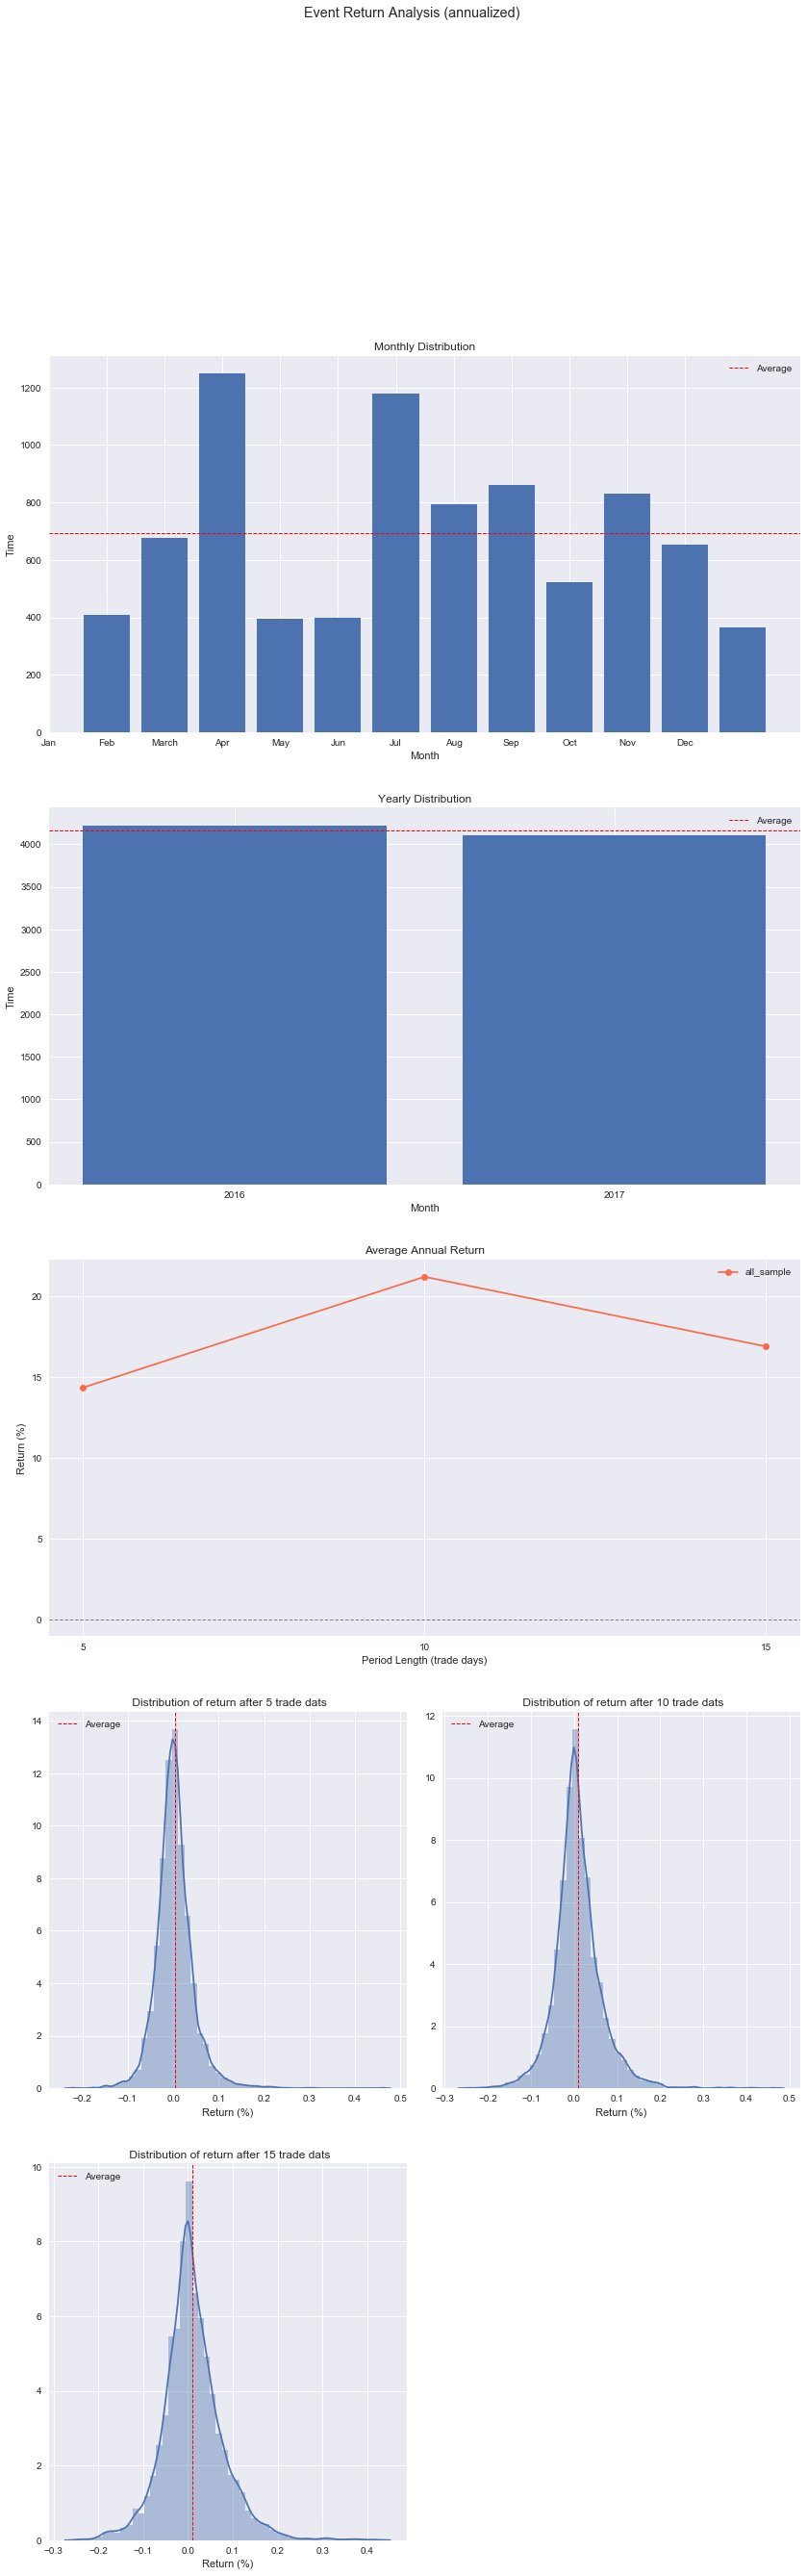

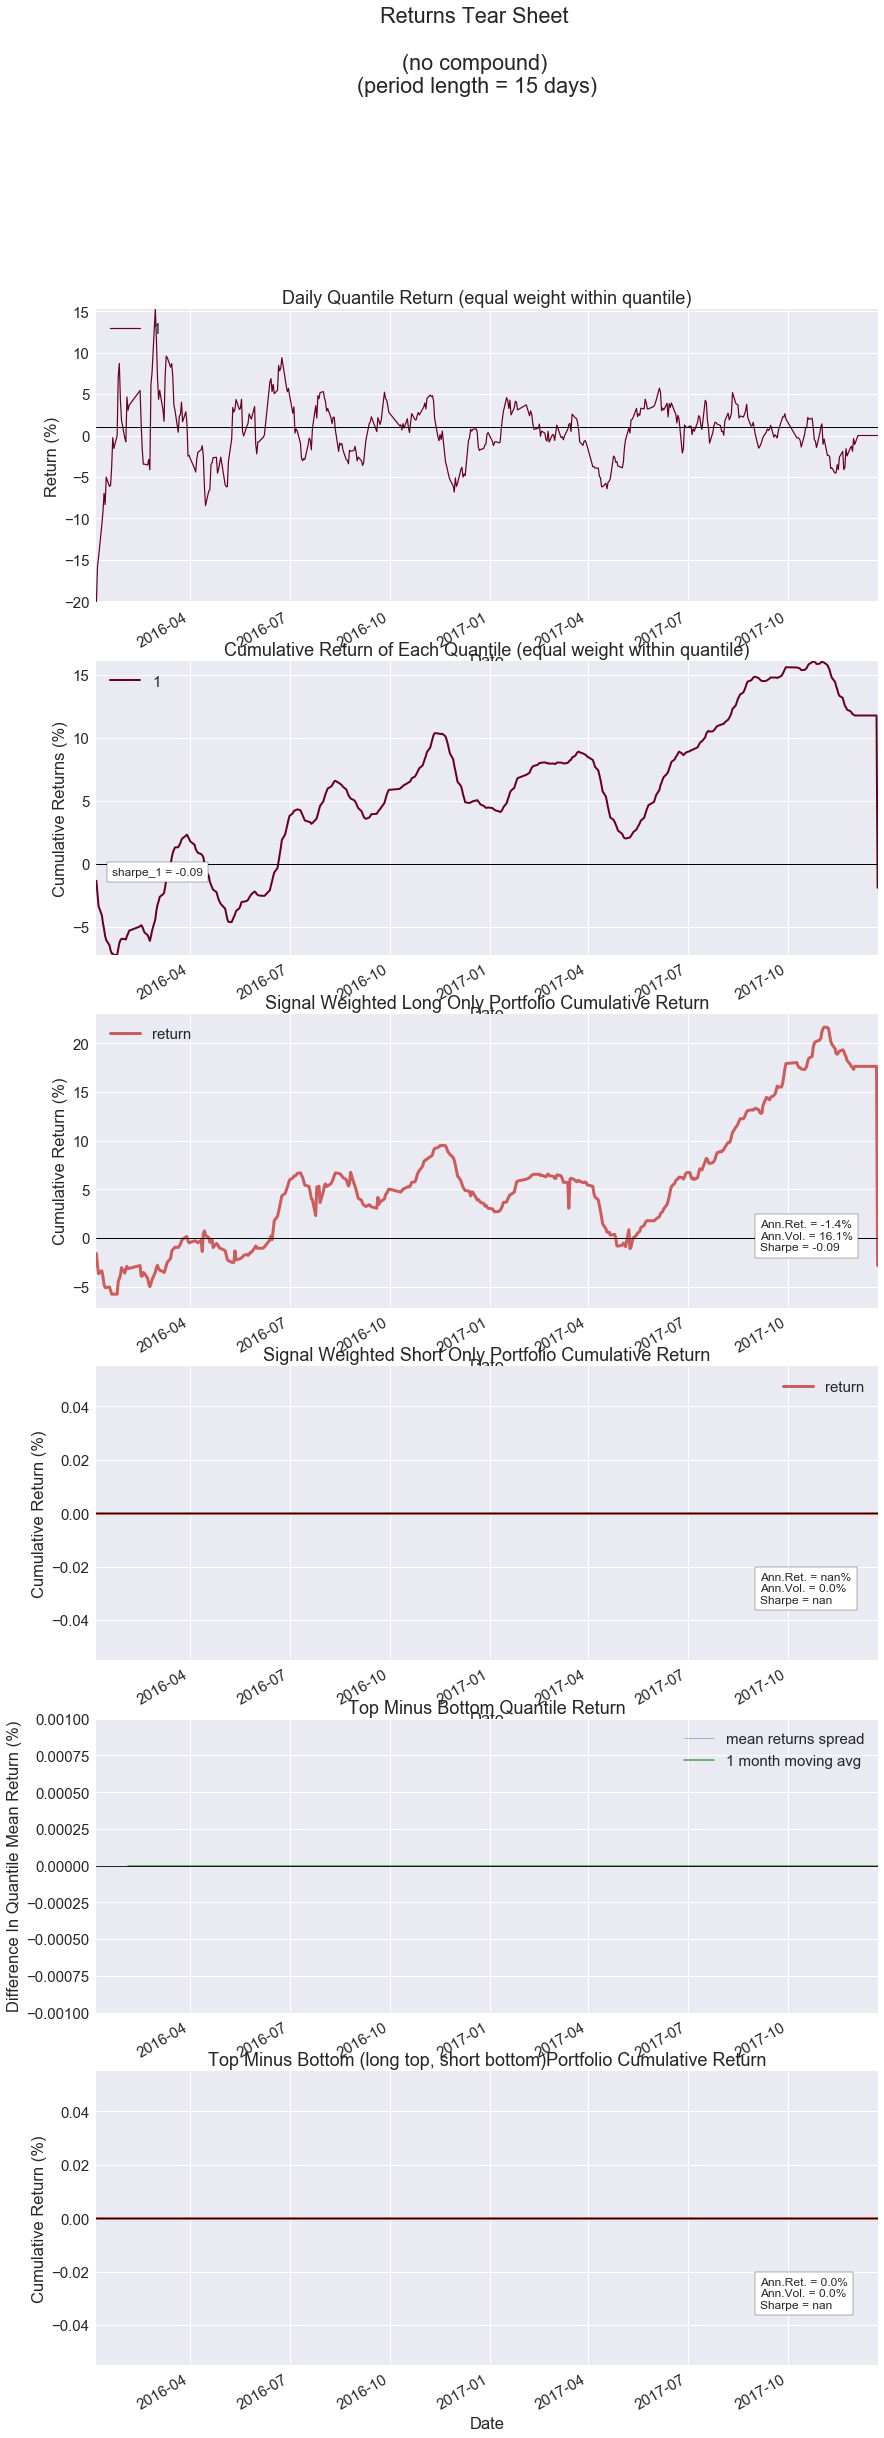

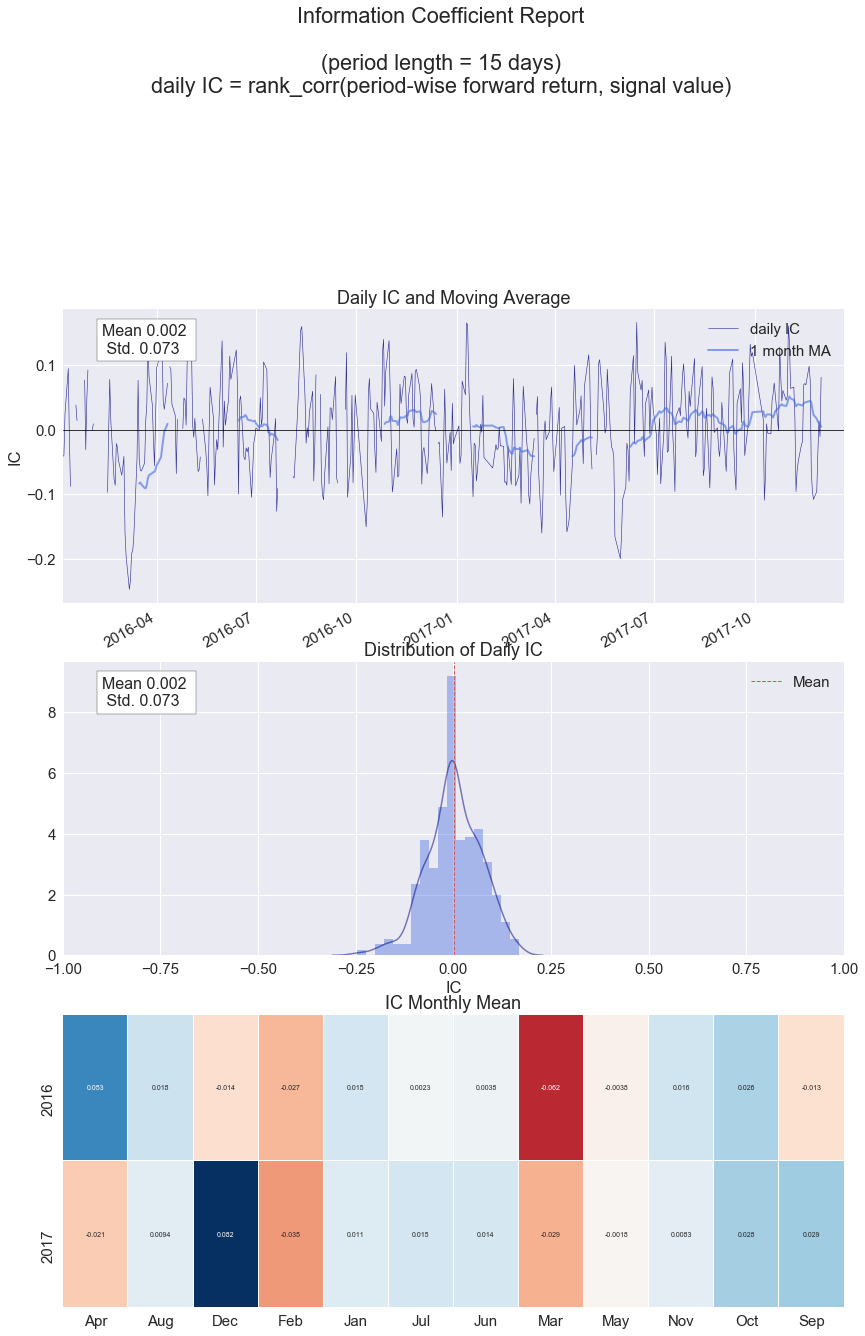

In [25]:
event_plot(dv.get_ts('Cross'),'Cross')